In [195]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [171]:
import os
import tensorflow as tf

In [172]:
train_path = 'tomato_apple/train'
valid_path = 'tomato_apple/test'

In [196]:
img_width, img_height = 224, 224
num_classes = 2

In [197]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

In [198]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_path,shuffle=True,batch_size=BATCH_SIZE,image_size=IMG_SIZE)

Found 294 files belonging to 2 classes.


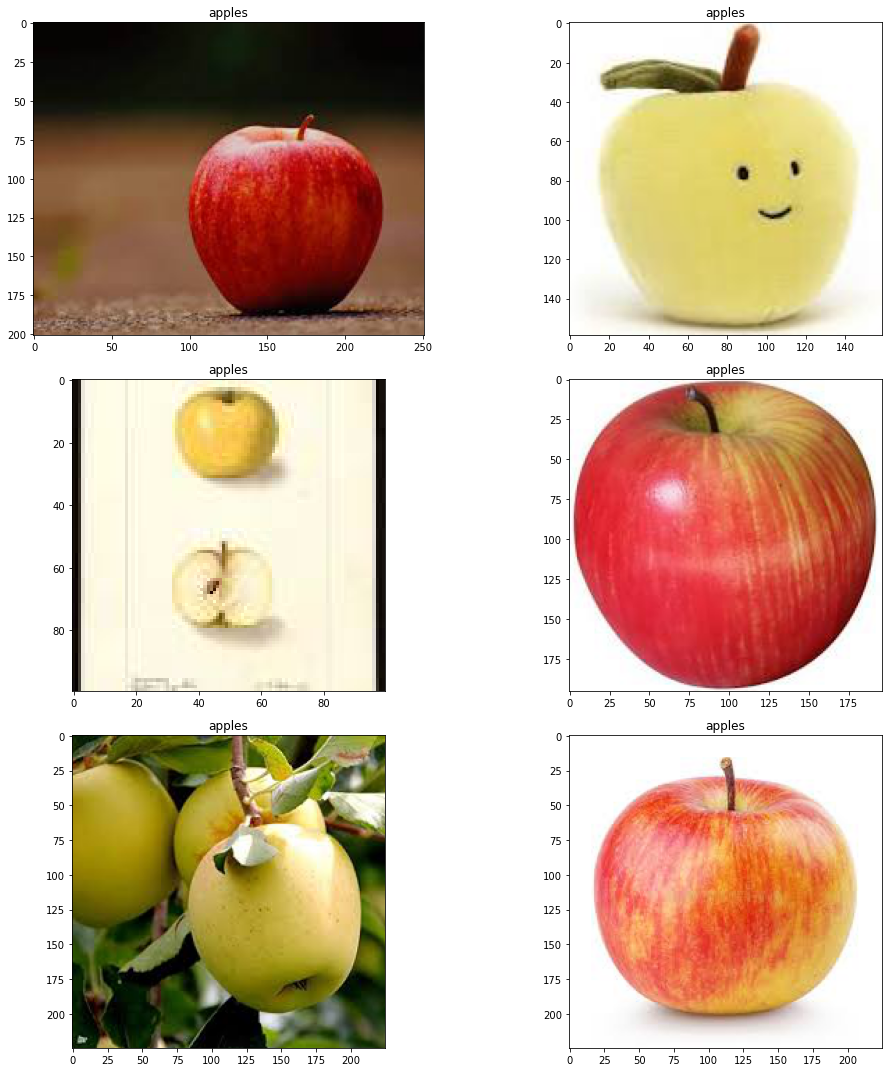

In [199]:
apple_folder = "tomato_apple/train/apples"
from PIL import Image
apple_images = os.listdir(apple_folder)
fig, ax = plt.subplots(3, 2)
fig.set_size_inches(15, 15)
for i in range(3):
    for j in range(2):
        random_image = random.choice(apple_images)
        image_path = os.path.join(apple_folder, random_image)
        img = Image.open(image_path)
        ax[i, j].imshow(img)
        ax[i, j].set_title("apples")
plt.tight_layout()
plt.show()

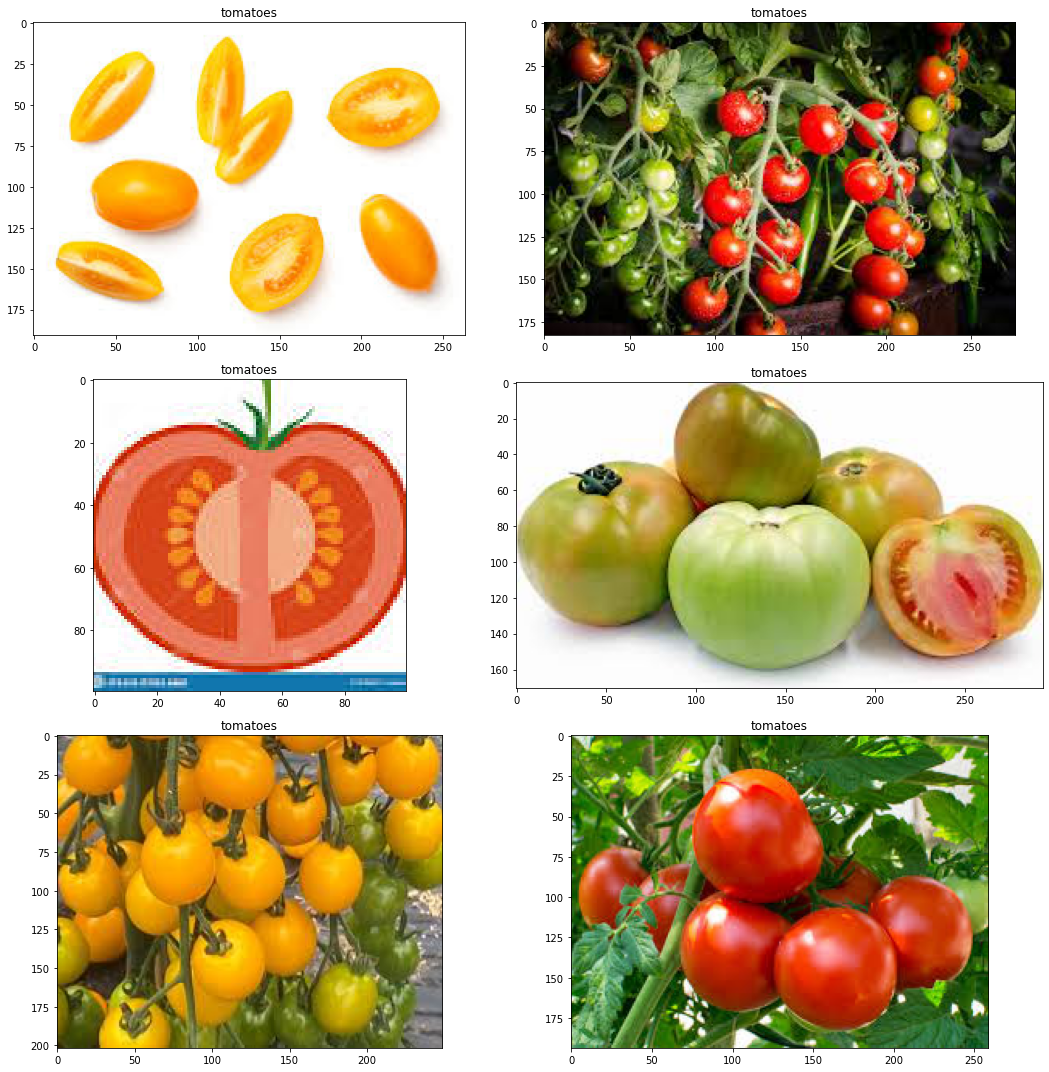

In [175]:
tomatoes_folder = "tomato_apple/train/tomatoes"
tomatoes_images = os.listdir(tomatoes_folder)
fig, ax = plt.subplots(3, 2)
fig.set_size_inches(15, 15)
for i in range(3):
    for j in range(2):
        random_image = random.choice(tomatoes_images)
        image_path = os.path.join(tomatoes_folder, random_image)
        img = Image.open(image_path)
        ax[i, j].imshow(img)
        ax[i, j].set_title("tomatoes")
plt.tight_layout()
plt.show()

In [200]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(valid_path,shuffle=True,batch_size=BATCH_SIZE,image_size=IMG_SIZE)

Found 97 files belonging to 2 classes.


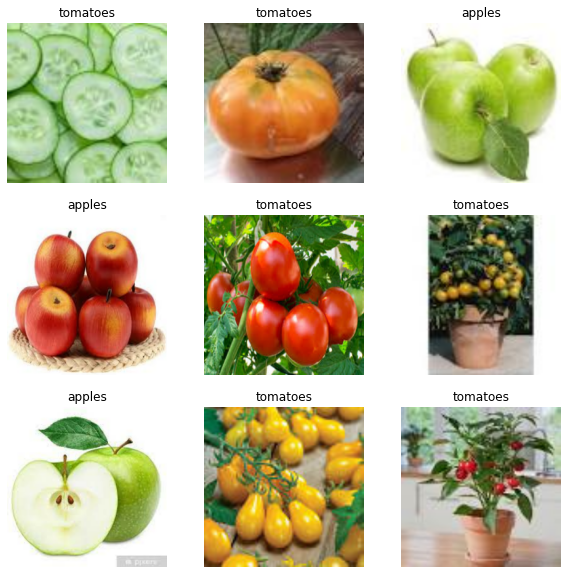

In [176]:
class_names = train_dataset.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [201]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 3)
validation_dataset = validation_dataset.skip(val_batches // 3)

In [202]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 3
Number of test batches: 1


In [203]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [204]:
data_augmentation = tf.keras.Sequential([
tf.keras.layers.RandomFlip('horizontal'),
tf.keras.layers.RandomRotation(0.2),
])

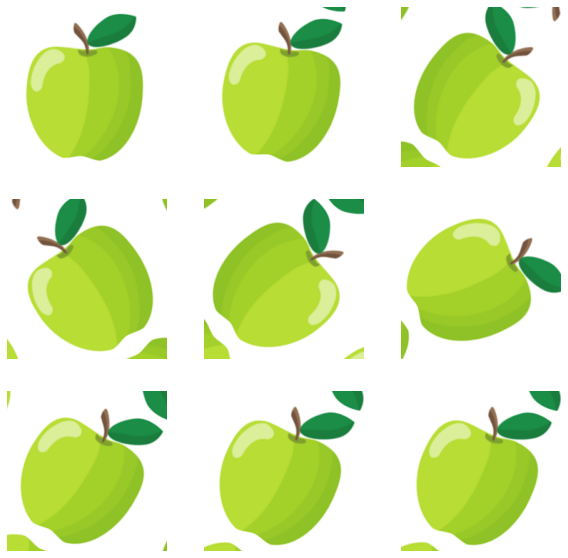

In [206]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [207]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [208]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [209]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,include_top=False,weights='imagenet')

In [210]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


In [211]:
base_model.trainable = False

In [212]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_12 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_12[0][0]']            
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

 block_3_expand_relu (ReLU)  (None, 56, 56, 144)          0         ['block_3_expand_BN[0][0]']   
                                                                                                  
 block_3_pad (ZeroPadding2D  (None, 57, 57, 144)          0         ['block_3_expand_relu[0][0]'] 
 )                                                                                                
                                                                                                  
 block_3_depthwise (Depthwi  (None, 28, 28, 144)          1296      ['block_3_pad[0][0]']         
 seConv2D)                                                                                        
                                                                                                  
 block_3_depthwise_BN (Batc  (None, 28, 28, 144)          576       ['block_3_depthwise[0][0]']   
 hNormalization)                                                                                  
          

 block_6_depthwise_BN (Batc  (None, 14, 14, 192)          768       ['block_6_depthwise[0][0]']   
 hNormalization)                                                                                  
                                                                                                  
 block_6_depthwise_relu (Re  (None, 14, 14, 192)          0         ['block_6_depthwise_BN[0][0]']
 LU)                                                                                              
                                                                                                  
 block_6_project (Conv2D)    (None, 14, 14, 64)           12288     ['block_6_depthwise_relu[0][0]
                                                                    ']                            
                                                                                                  
 block_6_project_BN (BatchN  (None, 14, 14, 64)           256       ['block_6_project[0][0]']     
 ormalizat

                                                                                                  
 block_9_add (Add)           (None, 14, 14, 64)           0         ['block_8_add[0][0]',         
                                                                     'block_9_project_BN[0][0]']  
                                                                                                  
 block_10_expand (Conv2D)    (None, 14, 14, 384)          24576     ['block_9_add[0][0]']         
                                                                                                  
 block_10_expand_BN (BatchN  (None, 14, 14, 384)          1536      ['block_10_expand[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block_10_expand_relu (ReLU  (None, 14, 14, 384)          0         ['block_10_expand_BN[0][0]']  
 )        

                                                                                                  
 block_13_expand_relu (ReLU  (None, 14, 14, 576)          0         ['block_13_expand_BN[0][0]']  
 )                                                                                                
                                                                                                  
 block_13_pad (ZeroPadding2  (None, 15, 15, 576)          0         ['block_13_expand_relu[0][0]']
 D)                                                                                               
                                                                                                  
 block_13_depthwise (Depthw  (None, 7, 7, 576)            5184      ['block_13_pad[0][0]']        
 iseConv2D)                                                                                       
                                                                                                  
 block_13_

 iseConv2D)                                                                                       
                                                                                                  
 block_16_depthwise_BN (Bat  (None, 7, 7, 960)            3840      ['block_16_depthwise[0][0]']  
 chNormalization)                                                                                 
                                                                                                  
 block_16_depthwise_relu (R  (None, 7, 7, 960)            0         ['block_16_depthwise_BN[0][0]'
 eLU)                                                               ]                             
                                                                                                  
 block_16_project (Conv2D)   (None, 7, 7, 320)            307200    ['block_16_depthwise_relu[0][0
                                                                    ]']                           
          

In [213]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [214]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [215]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [216]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
metrics=['accuracy'])

In [218]:
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_7 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_4 (TFOpLam  (None, 224, 224, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_4 (TFOpLa  (None, 224, 224, 3)       0         
 mbda)                                                           
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                           

In [219]:
len(model.trainable_variables)

2

In [220]:
initial_epochs = 10
loss0, accuracy0 = model.evaluate(validation_dataset)

3/3 [==============================] - 3s 334ms/step - loss: 0.7581 - accuracy: 0.4462


In [221]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.76
initial accuracy: 0.45


In [222]:
history = model.fit(train_dataset,epochs=10,validation_data=validation_dataset)

Epoch 1/10
10/10 [==============================] - 9s 655ms/step - loss: 0.7228 - accuracy: 0.5578 - val_loss: 0.6897 - val_accuracy: 0.5538
Epoch 2/10
10/10 [==============================] - 7s 658ms/step - loss: 0.7007 - accuracy: 0.6122 - val_loss: 0.7374 - val_accuracy: 0.5385
Epoch 3/10
10/10 [==============================] - 7s 651ms/step - loss: 0.6728 - accuracy: 0.5918 - val_loss: 0.6337 - val_accuracy: 0.6462
Epoch 4/10
10/10 [==============================] - 7s 658ms/step - loss: 0.6838 - accuracy: 0.6293 - val_loss: 0.6791 - val_accuracy: 0.5692
Epoch 5/10
10/10 [==============================] - 7s 659ms/step - loss: 0.6552 - accuracy: 0.6156 - val_loss: 0.6522 - val_accuracy: 0.6308
Epoch 6/10
10/10 [==============================] - 7s 683ms/step - loss: 0.6218 - accuracy: 0.6395 - val_loss: 0.6395 - val_accuracy: 0.6923
Epoch 7/10
10/10 [==============================] - 7s 715ms/step - loss: 0.6438 - accuracy: 0.6156 - val_loss: 0.6458 - val_accuracy: 0.6923
Epoch 

In [223]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

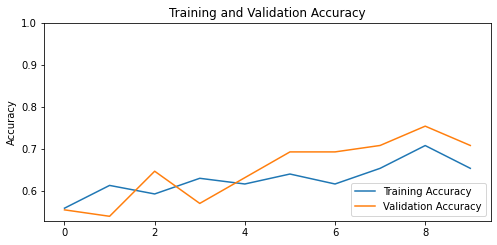

In [224]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

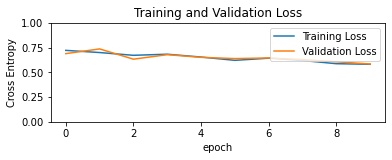

In [225]:
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [227]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))
# Fine-tune from this layer onwards
fine_tune_at = 100
# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in the base model:  154


In [231]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
metrics=['accuracy'])

In [232]:
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_7 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_4 (TFOpLam  (None, 224, 224, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_4 (TFOpLa  (None, 224, 224, 3)       0         
 mbda)                                                           
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                           

In [234]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs
history_fine = model.fit(train_dataset,epochs=total_epochs,initial_epoch=history.epoch[-1], validation_data=validation_dataset)

Epoch 10/20
10/10 [==============================] - 14s 1s/step - loss: 1.0019 - accuracy: 0.6429 - val_loss: 0.6045 - val_accuracy: 0.5846
Epoch 11/20
10/10 [==============================] - 10s 1s/step - loss: 0.4620 - accuracy: 0.7585 - val_loss: 0.6502 - val_accuracy: 0.7692
Epoch 12/20
10/10 [==============================] - 10s 956ms/step - loss: 0.4619 - accuracy: 0.7925 - val_loss: 0.3438 - val_accuracy: 0.8769
Epoch 13/20
10/10 [==============================] - 10s 958ms/step - loss: 0.3982 - accuracy: 0.8163 - val_loss: 0.7908 - val_accuracy: 0.5538
Epoch 14/20
10/10 [==============================] - 9s 941ms/step - loss: 0.2837 - accuracy: 0.8776 - val_loss: 0.5673 - val_accuracy: 0.7385
Epoch 15/20
10/10 [==============================] - 10s 987ms/step - loss: 0.2719 - accuracy: 0.8844 - val_loss: 0.1982 - val_accuracy: 0.9077
Epoch 16/20
10/10 [==============================] - 10s 1000ms/step - loss: 0.1610 - accuracy: 0.9286 - val_loss: 0.9701 - val_accuracy: 0.615

In [235]:
len(model.trainable_variables)

56

In [236]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs
history_fine = model.fit(train_dataset,epochs=total_epochs,initial_epoch=history.epoch[-1], validation_data=validation_dataset)

Epoch 10/20
10/10 [==============================] - 10s 958ms/step - loss: 0.2394 - accuracy: 0.9184 - val_loss: 0.2138 - val_accuracy: 0.9077
Epoch 11/20
10/10 [==============================] - 9s 949ms/step - loss: 0.0587 - accuracy: 0.9762 - val_loss: 0.2872 - val_accuracy: 0.8769
Epoch 12/20
10/10 [==============================] - 10s 943ms/step - loss: 0.1971 - accuracy: 0.9286 - val_loss: 0.2149 - val_accuracy: 0.9231
Epoch 13/20
10/10 [==============================] - 10s 965ms/step - loss: 0.0476 - accuracy: 0.9830 - val_loss: 0.4490 - val_accuracy: 0.8923
Epoch 14/20
10/10 [==============================] - 10s 962ms/step - loss: 0.0313 - accuracy: 0.9932 - val_loss: 0.3047 - val_accuracy: 0.9077
Epoch 15/20
10/10 [==============================] - 10s 956ms/step - loss: 0.0937 - accuracy: 0.9524 - val_loss: 0.7221 - val_accuracy: 0.7538
Epoch 16/20
10/10 [==============================] - 10s 968ms/step - loss: 0.0607 - accuracy: 0.9728 - val_loss: 0.2190 - val_accuracy: 

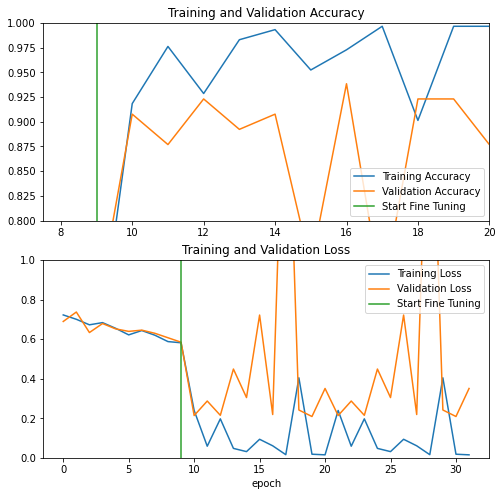

In [238]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.xlim([7.5,20])
plt.plot([initial_epochs-1,initial_epochs-1],
plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [239]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))
# Fine-tune from this layer onwards
fine_tune_at = 100
# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in the base model:  154


In [240]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

1/1 [==============================] - 1s 622ms/step - loss: 0.0580 - accuracy: 0.9688
Test accuracy : 0.96875


Predictions:
 [1 1 0 1 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 0 0 1 0 1 0]
Labels:
 [1 1 0 1 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 0 0 1 1 1 1]


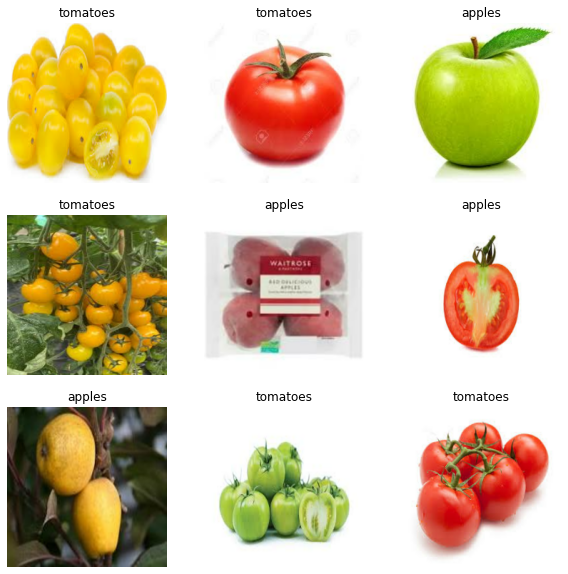

In [241]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]])
    plt.axis("off")